# 1. Notebook Setup
# Title, assignment info, and markdown overview.

In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import random as rd
import csv
from typing import Union
from typing import Callable
import time
from copy import deepcopy

In [4]:
mapping_file_path = "data/Mappings.csv"
employees_file_path = "data/Employee.csv"
tasks_file_path = "data/Tasks.csv"
rd.seed(20)

# Data Classes
class Task:
    time:int =0
    difficulty:int =0
    deadline:int = 0
    required_skill:str = ''
    def __str__(self):
        return f"T Time:{self.time} Difficulty:{self.difficulty} Deadline:{self.deadline} requiredSkill:{self.required_skill}"

class Employee:
    available_hours:int = 0
    skill_level:int = 4
    skills:list[str]=['']

    def __str__(self):
        return f"E AH:{self.available_hours} Skill-Level:{self.skill_level} Skills:{self.skills}"




In [25]:
# =========================
# I/O and Data Preparation
# =========================

"""
Task csv format:
'ID', 'Time (hrs)', 'Difficulty', 'Deadline (hrs)', 'Required Skill'

Employee csv format:
'Employee ID', 'Available Hrs', 'Skill Level', 'Skills'

Note:
- Using an adjacency list instead of an adjacency matrix for task-employee mappings.
- The input vector is 10 mappings x 11 features.
- Unique assignment penalty is not needed, as mapping a task to multiple employees would break the input structure for the network.
"""



# DataLoader handles loading tasks and employees from CSV files
class DataLoader:
    num_of_tasks = 10
    num_of_employees = 5
    tasks: list[Task] = []
    employees: list[Employee] = []

    def load_tasks(self, fileName=tasks_file_path):
        tasks = []
        with open(fileName, 'r') as csvfile:
            taskReader = csv.reader(csvfile)
            next(taskReader)  # Skip header
            for taskArr in taskReader:
                newT = Task()
                newT.time = int(taskArr[1])
                newT.difficulty = int(taskArr[2])
                newT.deadline = int(taskArr[3])
                newT.required_skill = taskArr[4]
                tasks.append(newT)
        self.tasks = tasks

    def load_employees(self, fileName=employees_file_path):
        employees = []
        with open(fileName, 'r') as csvfile:
            employeeReader = csv.reader(csvfile)
            next(employeeReader)  # Skip header
            for employeeArr in employeeReader:
                newEmployee = Employee()
                newEmployee.available_hours = int(employeeArr[1])
                newEmployee.skill_level = int(employeeArr[2])
                skills = employeeArr[3].split(',')
                newEmployee.skills = skills
                employees.append(newEmployee)
        self.employees = employees

    def loadAll(self):
        # Load both employees and tasks
        self.load_employees()
        self.load_tasks()


# MappingHandler manages the generation, evaluation, and storage of task-employee mappings
class MappingHandler:
    def __init__(self, tasks: list[Task], employees: list[Employee], num_of_mappings=10000):
        self.tasks: list[Task] = tasks
        self.employees: list[Employee] = employees
        self.num_of_mappings = num_of_mappings
        self.mappings: list[list[int]] = []  # Each mapping is a list of employee indices for each task
        self.costs: list[float] = []         # Penalty/cost for each mapping

    def __costFunction(self, Mapping: list[int]):
        # Penalty weights and counters
        w = 0.2
        overload = 0
        skill_mismatch = 0
        difficulty_violation = 0
        deadline_violation = 0
        # Adjacency list: for each employee, list of assigned tasks
        employee_task_adj_list: list[list[Task]] = [[] for _ in range(len(self.employees))]

        for i in range(len(Mapping)):
            taskId = i
            task = self.tasks[taskId]
            num_of_employees_assigned = 0
            employeeId = Mapping[i]
            num_of_employees_assigned += 1
            employee = self.employees[employeeId]
            employee_task_adj_list[employeeId].append(task)
            # Penalty: skill mismatch
            if task.required_skill not in employee.skills:
                skill_mismatch += 1
            # Penalty: difficulty violation
            if task.difficulty > employee.skill_level:
                difficulty_violation += task.difficulty


        # Check overload and deadline violations for each employee
        for employeeId in range(len(employee_task_adj_list)):
            employee = self.employees[employeeId]
            sortedEmployeeTasks = employee_task_adj_list[employeeId]
            sortedEmployeeTasks.sort(key=lambda x: x.time)
            sumHours = 0
            finishTime = 0
            for t in sortedEmployeeTasks:
                sumHours += t.time
                finishTime += t.time
                deadline_violation += max(0, finishTime - t.deadline)
            overload += max(0, sumHours - employee.available_hours)
        total_penalty = overload + skill_mismatch  + deadline_violation + difficulty_violation
        return round(total_penalty * w, 3)

    def __reset(self):
        # Reset mappings and costs
        self.mappings = []
        self.costs = []
    def test_cost(self):
        expected_penalty = 5
        mapping=[2,3,1,4,2,5,1,3,5,4]
        mapping = [n-1 for n in mapping]
        cost = self.__costFunction(mapping)
        print(cost)
        print(cost == expected_penalty)
    def generateMappings(self):
        # Generate random mappings and compute their penalties
        unique = set()
        self.__reset()
        while len(unique) < self.num_of_mappings:
            mapping: list[int] = [0 for _ in self.tasks]  # One employee per task
            for taskId in range(len(self.tasks)):
                rand_employee = rd.randint(0, len(self.employees) - 1)
                mapping[taskId] = rand_employee
            string = str(mapping)
            if string not in unique:  # Ensure no duplicates
                unique.add(string)
                self.mappings.append(mapping)
                self.costs.append(self.__costFunction(mapping))

    def readCSV(self, fileName=mapping_file_path):
        # Load mappings and costs from CSV
        self.__reset()
        with open(fileName, 'r') as csvfile:
            mappingReader = csv.reader(csvfile)
            next(mappingReader)
            for line in mappingReader:
                newMapping: list[int] = []
                for v in line:
                    if v.isdigit():
                        newMapping.append(int(v))
                    else:
                        self.costs.append(float(v))
                self.mappings.append(newMapping)

    def writeCSV(self, filepath=mapping_file_path):
        # Save mappings and costs to CSV
        with open(filepath, 'w', newline='') as csvfile:
            mappingWriter = csv.writer(csvfile, delimiter=',')
            mappingWriter.writerow(["T1", 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'Penalty'])
            for i in range(len(self.mappings)):
                row = []
                row.extend(self.mappings[i])
                row.append(f"{self.costs[i]}")
                mappingWriter.writerow(row)




# Test data generation: creates and saves random mappings for use in the rest of the notebook
def testDataGen():
    dl = DataLoader()
    dl.loadAll()
    mappingloader = MappingHandler(dl.tasks, dl.employees)
    mappingloader.test_cost()
    mappingloader.generateMappings()
    mappingloader.writeCSV('data/Mappings.csv')

testDataGen()

5.0
True


In [19]:
# =========================
# Data PreProcessing
# =========================

# Function to one-hot encode a skill vector (e.g., ['A', 'B', 'C'])
# It returns a 3-element vector where each skill is encoded as 1 if present, else 0.
def one_hot_encode_skill(skillsVector):
    skills = ['A', 'B', 'C']  # Define possible skills
    hot_encoding = []  # Initialize the result list
    j = 0  # Initialize the index for skillsVector

    # Loop over all possible skills and check if the skill exists in the skillsVector
    for i in range(len(skills)):
        # If the current skill is in the skillsVector, set encoding to 1
        if j < len(skillsVector) and skills[i] == skillsVector[j]:
            j += 1
            hot_encoding.append(1)
        else:
            # Otherwise, set encoding to 0
            hot_encoding.append(0)
    
    return hot_encoding


# Z-normalization function for scaling values (e.g., time, difficulty)
# Standardize a value using mean (mu) and standard deviation (sigma)
def z_normalize(x, mu, sigma):
    return (x - mu) / (sigma + 1e-8)


# Get statistics (mean, std) of relevant features from the mapping loader
def getStats(mappingloader: MappingHandler):
    all_times = []
    all_difficulties = []
    all_deadlines = []
    all_avails = []
    all_levels = []

    # Iterate over all the task-employee mappings
    for mapping in mappingloader.mappings:
        for task_idx, emp_idx in enumerate(mapping):
            task = mappingloader.tasks[task_idx]  # Get the task object
            employee = mappingloader.employees[emp_idx]  # Get the employee object

            # Collect various features for statistics calculation
            all_times.append(task.time)
            all_difficulties.append(task.difficulty)
            all_deadlines.append(task.deadline)
            all_avails.append(employee.available_hours)
            all_levels.append(employee.skill_level)

    # Calculate the mean and standard deviation for each feature
    stats = {
        "time": (np.mean(all_times), np.std(all_times)),
        "difficulty": (np.mean(all_difficulties), np.std(all_difficulties)),
        "deadline": (np.mean(all_deadlines), np.std(all_deadlines)),
        "available_hours": (np.mean(all_avails), np.std(all_avails)),
        "skill_level": (np.mean(all_levels), np.std(all_levels)),
    }
    
    return stats


# Construct the input vector
def construct_input_vector(mappingloader: MappingHandler):
    featureVector = []  # Initialize list to hold all feature vectors
    stats = getStats(mappingloader)  

    # Iterate through each mapping (task-employee pairing)
    for idx, mp in enumerate(mappingloader.mappings):
        vector = []  # Initialize vector for the current mapping

        # Loop through each task-employee pair in the mapping
        for i in range(len(mp)):
            task = mappingloader.tasks[i]  
            employee = mappingloader.employees[mp[i]]  

            # Normalize and append  features of the task and employee
            vector.append(z_normalize(task.time, *stats["time"]))
            vector.append(z_normalize(task.difficulty, *stats["difficulty"]))
            vector.append(z_normalize(task.deadline, *stats["deadline"]))
            vector.extend(one_hot_encode_skill(task.required_skill)) 
            vector.append(z_normalize(employee.available_hours, *stats["available_hours"]))
            vector.append(z_normalize(employee.skill_level, *stats["skill_level"]))
            vector.extend(one_hot_encode_skill(employee.skills))  
            
        # Append the cost (target variable) for the current mapping
        vector.append(mappingloader.costs[idx])
        featureVector.append(vector) 

    df = DataFrame(featureVector)
    return df


# Split the dataset into training, validation, and test sets (70%, 15%, 15%)
def split_train_val_test(df: DataFrame):
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the DataFrame

    train_size = int(0.7 * len(df_shuffled))  # 70% for training
    val_size = int(0.15 * len(df_shuffled))  # 15% for validation

    train_df = df_shuffled[:train_size]
    val_df = df_shuffled[train_size:train_size + val_size]
    test_df = df_shuffled[train_size + val_size:]
    
    return train_df, val_df, test_df


# Split the DataFrame into X (features) and Y (target) for model input
def split_x_y(df: DataFrame):

    x = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    
    return x, y


def create_batches(data: DataFrame, batch_size: int):
    batches = []
    for i in range(0, len(data), batch_size):
        batches.append(data[i:i + batch_size]) 
    return batches


# Main preprocessing function
def pre_process():
    # Initialize DataLoader and load all necessary data
    dl = DataLoader()
    dl.loadAll()

    # Initialize MappingHandler and read CSV file containing mappings
    mappingloader = MappingHandler(dl.tasks, dl.employees)
    mappingloader.readCSV('data/Mappings.csv')

    df = construct_input_vector(mappingloader)

    # Split the dataset into training, validation, and test sets
    return split_train_val_test(df)





In [ ]:
# =========================
# Neural Network Model
# =========================



#Activation functions
def sig(x):
    return 1/(1+np.exp(-np.clip(x, -500, 500)))  # Clip to prevent overflow

def sig_derivative(x):
    s = sig(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def linear(x):
    return x

def linear_derivative(x):
    return np.ones_like(x)

def mse(y_true, y_pred):
    y_pred = y_pred.reshape(-1)
    return np.mean((y_true - y_pred)**2)

def mse_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true)


#
architecture={
    'A':[110,256,1],  #110 input, 256 Hidden, 1 output
    'B':[110,128,128,1]  #110 input , 128 Hidden, 128 Hidden , 1 ouput
}


#Neural network arguments
class NeuralNetworkArgs:

    def __init__(self,name):
        self.name = name
        self.layer_dims = architecture[self.name]
        self.activation:Callable[[np.ndarray],np.ndarray]=sig
        self.activation_derivative:Callable[[np.ndarray],np.ndarray] = sig_derivative
        self.lr=0.01
        self.output_activation:Callable[[np.ndarray],np.ndarray] = linear
        self.output_activation_derivative = linear_derivative
        self.epochs=200
        self.batch_size=8


#Best weights and biases to save
class Best:
    def __init__(self,biases,weights):
        self.biases= deepcopy(biases)
        self.weights= deepcopy(weights)
        self.lowest_val_loss=float("inf")


#Main neural network class
class NeuralNetwork:
    
    def __init__(self, neuralArgs:NeuralNetworkArgs):
        # load arguments
        self.name = neuralArgs.name
        self.layer_dims= neuralArgs.layer_dims
        self.weights = []
        self.biases= []
        self.activation = neuralArgs.activation
        self.activation_derivative = neuralArgs.activation_derivative
        self.output_activation = neuralArgs.output_activation
        self.output_activation_derivative = neuralArgs.output_activation_derivative
        self.lr= neuralArgs.lr
        self.batch_size = neuralArgs.batch_size
        self.epochs = neuralArgs.epochs

        # Intialize weights and biases
        for i in range(1,len(self.layer_dims)):
            w = np.random.normal(loc=0.0, scale=0.01, size=(self.layer_dims[i], self.layer_dims[i-1]))
            self.weights.append(w)
            b= np.zeros((self.layer_dims[i],1))
            self.biases.append(b)
        self.best= Best(self.biases,self.weights)
        
    # save current best
    def snapshot(self,val_loss):
        if val_loss< self.best.lowest_val_loss:
            self.best.weights = deepcopy(self.weights)
            self.best.biases = deepcopy(self.biases)
            self.best.lowest_val_loss = val_loss
        

    # perform forward-feed
    def forward(self, x):
        
        cache_a=[x.T]
        cache_z=[]
        for i in range(len(self.layer_dims)-1):
            z=self.weights[i].dot(cache_a[i])+self.biases[i]
            if i == len(self.layer_dims) - 2:  # Output layer
                a = self.output_activation(z)
            else:
                a = self.activation(z)
            cache_a.append(a)
            cache_z.append(z)
        return cache_a,cache_z

    #backward prop
    def backward(self,y_true,cache_a,cache_z):
        grads={}
        deltas=[]
        y_true = np.array(y_true)
        if y_true.ndim == 1:
            y_true = y_true.reshape(1, -1) 
        #Output layer
        delta_output = 2* (cache_a[-1]-y_true) * self.output_activation_derivative(cache_z[-1])
        deltas.append(delta_output)

        #hidden layers
        current_delta = delta_output

        for l in range(len(self.layer_dims)-2,0,-1):
            delta_hidden = self.weights[l].T.dot(current_delta) * self.activation_derivative(cache_z[l-1])
            deltas.insert(0, delta_hidden)
            current_delta = delta_hidden

        for l in range(len(self.weights)):
            # ∂L/∂W^(l) = δ^(l) (a^(l-1))^T
            dW = deltas[l].dot(cache_a[l].T)
            
            # ∂L/∂b^(l) = δ^(l)
            db = np.sum(deltas[l], axis=1, keepdims=True)
            
            grads[f'dW{l+1}'] = dW
            grads[f'db{l+1}'] = db
        
        return grads


    # update parameters using gradients
    def update_params(self,grads):
        for l in range(len(self.weights)):
            grads[f'dW{l+1}'] = np.clip(grads[f'dW{l+1}'], -1, 1)
            grads[f'db{l+1}'] = np.clip(grads[f'db{l+1}'], -1, 1)
            self.weights[l] -= self.lr * grads[f'dW{l+1}']
            self.biases[l] -= self.lr * grads[f'db{l+1}']
    


    # 6. Training Loop
    def train(self, trainData:DataFrame,valData:DataFrame,useBest=True,silent=False):
        train_losses=[]
        val_losses=[]
        epoch_times=[]
        if useBest:
            self.weights = self.best.weights
            self.biases = self.best.biases
        

        for e in range(self.epochs):
            start = time.time()
            trainData = trainData.sample(frac=1).reset_index(drop=True)
            batches = create_batches(trainData,self.batch_size)
            train_loss =0
            for batch in batches:
                #main loop
                x_train,y_train =split_x_y(batch)

                cache_a,cache_z = self.forward(x_train)

                train_loss+=mse(y_train,cache_a[-1])

                grads = self.backward(y_train,cache_a,cache_z)

                self.update_params(grads)

            end = time.time()
            train_loss= train_loss/len(batches)
            val_pred, val_loss = self.evaluate(valData)
            total_time = round(end-start,3)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            epoch_times.append(total_time)
            self.snapshot(val_loss)
            if not silent:
                print(f"Epoch: {e}   time:  {total_time}   train_loss: {train_loss}   val_loss: {val_loss}")
        return train_losses,val_losses,epoch_times


    def evaluate(self,evalData):
        x,y_true =split_x_y(evalData)
        cache_a,cache_z = self.forward(x)
        return cache_a[-1],mse(y_true,cache_a[-1])

    def predict(self,predData):
        return self.forward(predData)[0][-1]




def test():
    trainData,valData,testData = pre_process()
    args = NeuralNetworkArgs('A')
    nn = NeuralNetwork(args)
    print(nn.best.lowest_val_loss)
    nn.epochs=100
    nn.train(trainData,valData)
    test_pred,test_loss = nn.evaluate(testData)



test()




In [21]:
class HyperArgs:
    names=['A','B']
    lr=[0.01, 0.001, 0.0001]
    batch_size=[8,16,32]
    epochs=[100,150,200]
    activations=[[sig,sig_derivative],[relu,relu_derivative]]
    def totalRuns(self):
        return len(self.names) * len(self.lr) * len(self.batch_size) * len(self.epochs) * len(self.activations)


# Perfrom grid search on specified Arguments
def hyper_grid_search(gridArgs:HyperArgs):
    trainData,valData,testData = pre_process()
    results=[]
    total_runs = gridArgs.totalRuns()
    run=0
    # loop through all possible compinations
    for name in gridArgs.names:
        for lr in gridArgs.lr:
            for batch in gridArgs.batch_size:
                for epoch in gridArgs.epochs:
                    for activation in gridArgs.activations:
                        print(f"Iteration: {run}/{total_runs}")
                        run+=1
                        args = NeuralNetworkArgs(name)
                        args.lr = lr
                        args.batch_size = batch
                        args.epochs = epoch
                        args.activation = activation[0]
                        args.activation_derivative = activation[1]
                        args.layer_dims = architecture[name]
                        nn= NeuralNetwork(args)
                        nn.train(trainData,valData,silent=True)
                        results.append({
                            "model_name": name,
                            "lr": lr,
                            "batch_size": batch,
                            "epochs": epoch,
                            "activation": activation[0].__name__,
                            "val_loss": nn.best.lowest_val_loss,
                            "nn": nn  
                        })
    results.sort(key= lambda x: x['val_loss'])
    top_15 = results[:15]
    for i, res in enumerate(top_15, 1):
        print(f"#{i}: Model={res['model_name']}, LR={res['lr']}, Batch={res['batch_size']}, "
            f"Epochs={res['epochs']}, Act={res['activation']}, Val Loss={res['val_loss']:.4f}")
    return results


In [10]:
results = hyper_grid_search(HyperArgs())

Iteration: 0/108


KeyboardInterrupt: 

In [182]:
for i, res in enumerate(results, 1):
        print(f"#{i}: Model={res['model_name']}, LR={res['lr']}, Batch={res['batch_size']}, "
            f"Epochs={res['epochs']}, Act={res['activation']}, Val Loss={res['val_loss']:.4f}")

#1: Model=A, LR=0.01, Batch=8, Epochs=200, Act=relu, Val Loss=3.3806
#2: Model=A, LR=0.01, Batch=32, Epochs=100, Act=relu, Val Loss=3.4554
#3: Model=B, LR=0.01, Batch=16, Epochs=150, Act=relu, Val Loss=3.4762
#4: Model=B, LR=0.01, Batch=8, Epochs=150, Act=relu, Val Loss=3.5512
#5: Model=A, LR=0.01, Batch=16, Epochs=200, Act=relu, Val Loss=3.5808
#6: Model=A, LR=0.01, Batch=16, Epochs=100, Act=sig, Val Loss=3.6764
#7: Model=B, LR=0.001, Batch=8, Epochs=100, Act=relu, Val Loss=3.7382
#8: Model=A, LR=0.01, Batch=32, Epochs=150, Act=sig, Val Loss=3.7382
#9: Model=A, LR=0.01, Batch=8, Epochs=200, Act=sig, Val Loss=3.7401
#10: Model=A, LR=0.01, Batch=8, Epochs=150, Act=sig, Val Loss=3.7578
#11: Model=A, LR=0.01, Batch=16, Epochs=100, Act=relu, Val Loss=3.7785
#12: Model=A, LR=0.01, Batch=16, Epochs=150, Act=relu, Val Loss=3.7864
#13: Model=B, LR=0.001, Batch=8, Epochs=150, Act=relu, Val Loss=3.7887
#14: Model=B, LR=0.01, Batch=16, Epochs=100, Act=relu, Val Loss=3.8045
#15: Model=B, LR=0.001,

In [26]:
a_args = NeuralNetworkArgs('A')
b_args = NeuralNetworkArgs('B')

a_nn = NeuralNetwork(a_args)
b_nn = NeuralNetwork(b_args)

models=[a_nn,b_nn]

hyperArgs = HyperArgs()

trainData, valData, testData = pre_process()

KeyboardInterrupt: 

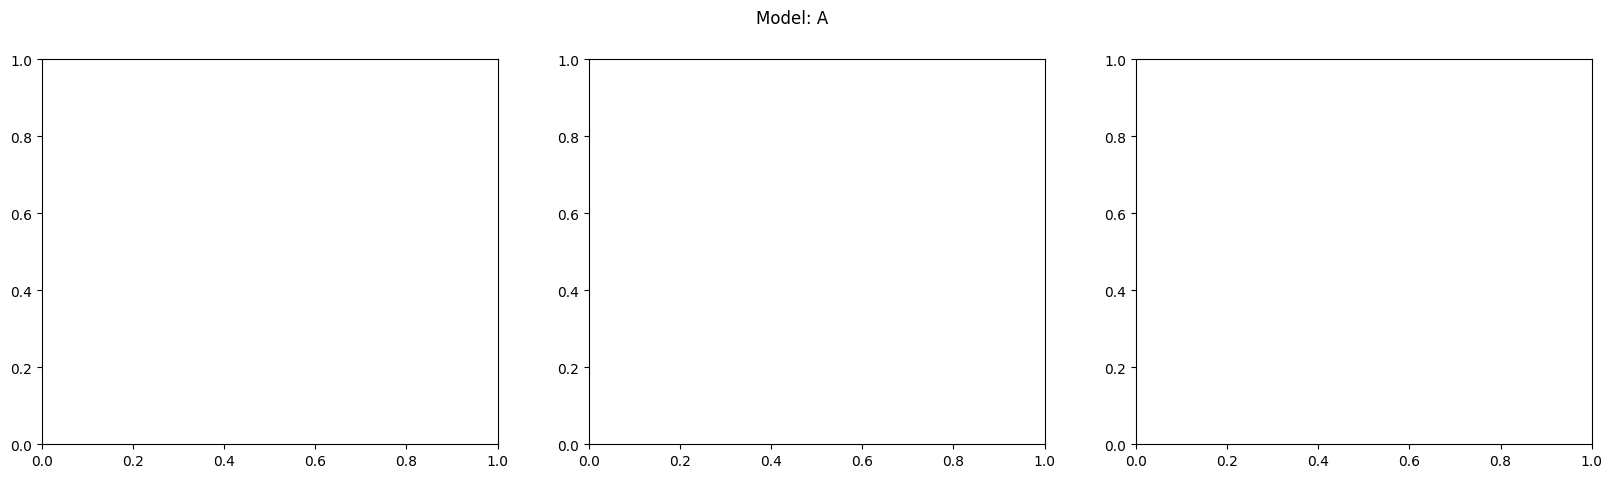

In [27]:
# =========================
# Plots and benchmarks
# =========================


#learning_rate
for model in models:
    fig, axs = plt.subplots(1, len(hyperArgs.lr), figsize=(20, 5))
    fig.suptitle(f"Model: {model.name}")

    for idx, lr in enumerate(hyperArgs.lr):
        # Create fresh args & model for each run

        nn = NeuralNetwork(NeuralNetworkArgs(model.name))
        nn.lr = lr
        nn.name= model.name
        nn.epochs=100

        train_losses, val_losses,_ = nn.train(trainData, valData, useBest=False, silent=True)

        axs[idx].plot(train_losses, label="Train Loss")
        axs[idx].plot(val_losses, label="Val Loss")
        axs[idx].set_title(f"lr = {lr}")
        axs[idx].set_xlabel("Epoch")
        axs[idx].set_ylabel("Loss")
        axs[idx].legend()


    plt.show()


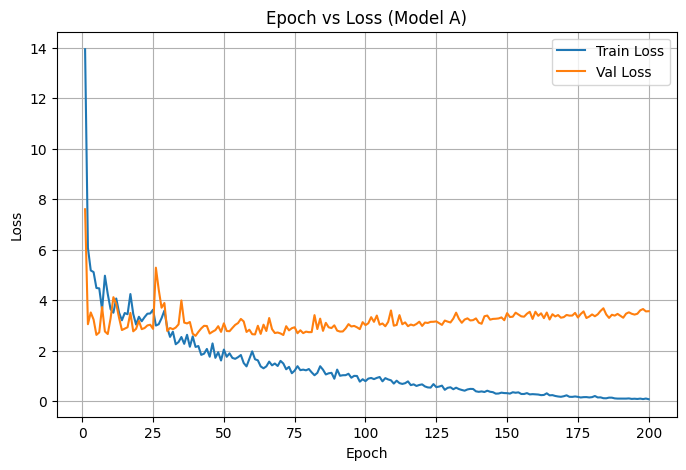

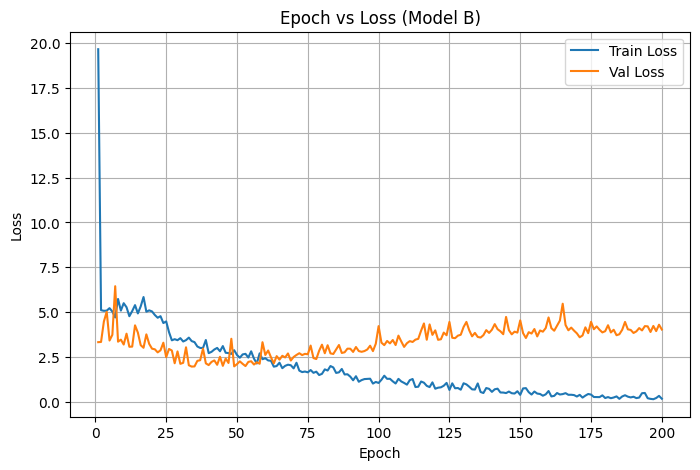

In [24]:
# =========================
# Epoch vs loss
# =========================



for model in models:
    nn = NeuralNetwork(NeuralNetworkArgs(model.name))
    train_losses, val_losses,_ = nn.train(trainData, valData,useBest=False,silent=True)
    
    epochs = list(range(1, nn.epochs + 1))
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title(f"Epoch vs Loss (Model {nn.name})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    plt.show()

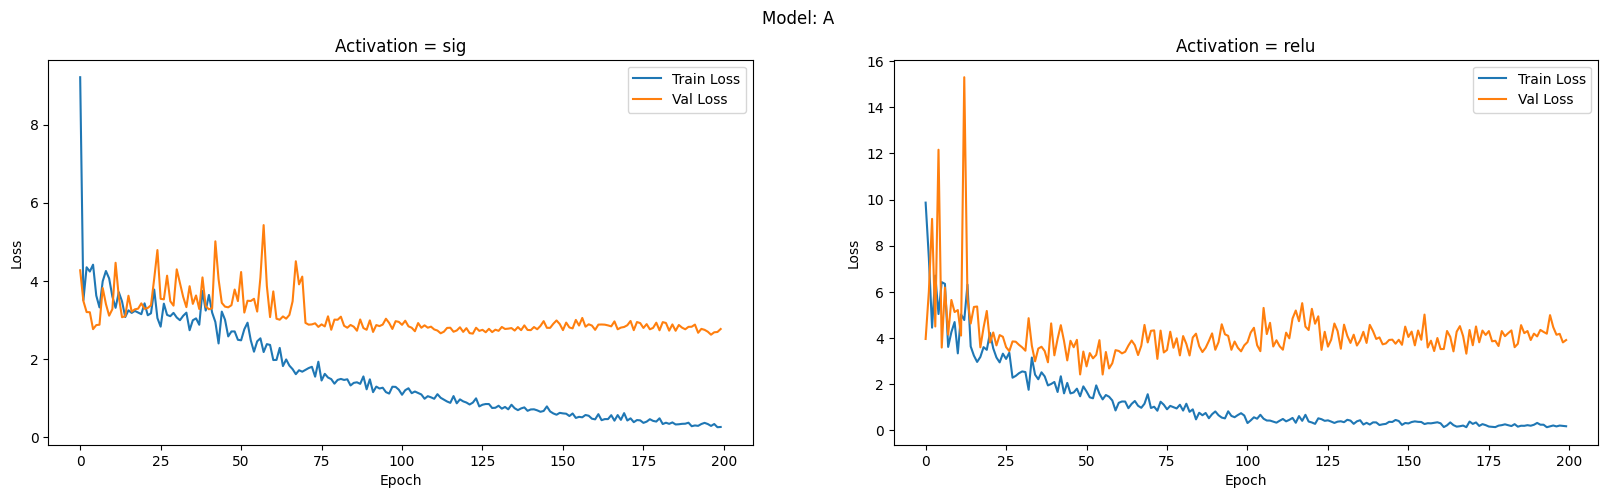

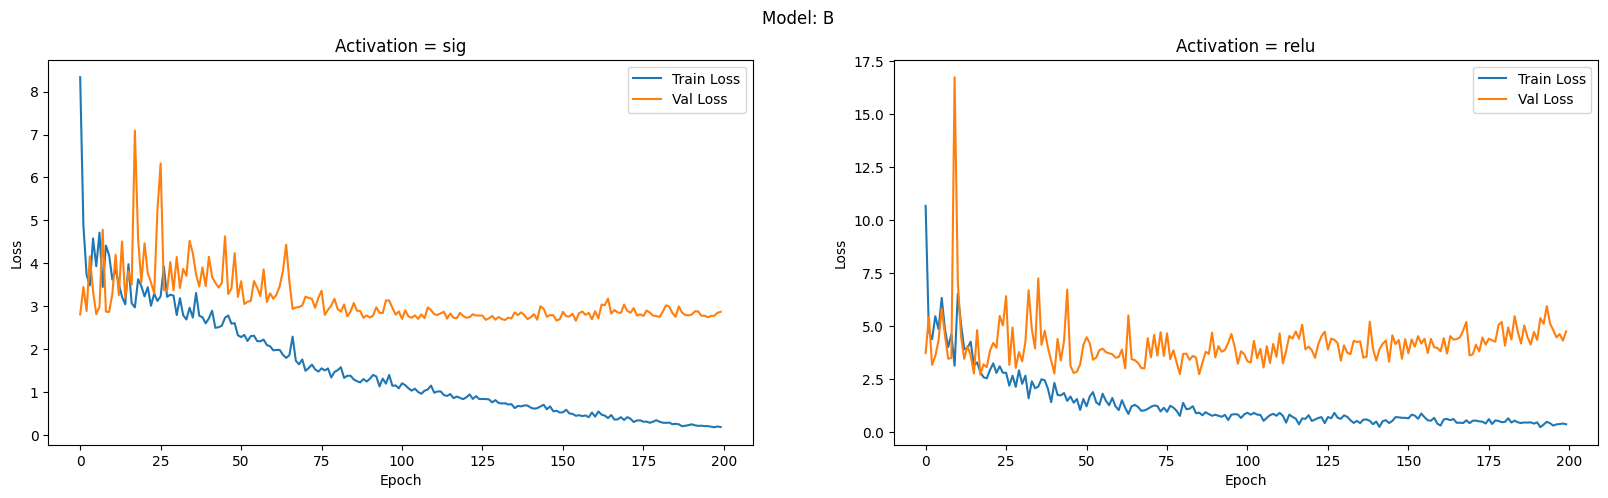

In [ ]:

# =========================
# Activation Plots (Relu, sigmoid)
# =========================

for model in models:
    fig, axs = plt.subplots(1, len(hyperArgs.activations), figsize=(20, 5))
    fig.suptitle(f"Model: {model.name}")

    for idx,act  in enumerate(hyperArgs.activations):
        # Create fresh args & model for each run
        nn = NeuralNetwork(hyperArgs)
        nn.activation = act[0]
        nn.activation_derivative = act[1]
        nn.name= model.name
        nn.epochs=200

        train_losses, val_losses,_ = nn.train(trainData, valData, useBest=False, silent=True)

        axs[idx].plot(train_losses, label="Train Loss")
        axs[idx].plot(val_losses, label="Val Loss")
        axs[idx].set_title(f"Activation = {nn.activation.__name__}")
        axs[idx].set_xlabel("Epoch")
        axs[idx].set_ylabel("Loss")
        axs[idx].legend()


    plt.show()

In [1]:
# =========================
# Batch size plots
# =========================

for model in models:
    fig, axs = plt.subplots(1, len(hyperArgs.batch_size), figsize=(20, 5))
    fig.suptitle(f"Model: {model.name}")

    for idx,batch  in enumerate(hyperArgs.batch_size):
        # Create fresh args & model for each run
        nn = NeuralNetwork(hyperArgs)
        nn.batch_size = batch
        nn.name= model.name
        nn.epochs=200

        train_losses, val_losses,epoch_times = nn.train(trainData, valData, useBest=False, silent=True)

        axs[idx].plot(epoch_times, label="Epoch Time")
        axs[idx].set_title(f"Batch Size = {nn.batch_size}")
        axs[idx].set_xlabel("Epoch")
        axs[idx].set_ylabel("Epoch Time")
        axs[idx].legend()


    plt.show()

NameError: name 'models' is not defined